# Section 1. Loading the Data

### 1.1. Loading required passages (TensorFlow, NumPy, Pandas, CV2)

Importing needed packages.

**Essential Note:**
If you would like to test _Keras Facenet Feature Extraction_ which I use here, you should use older versions of _Keras_, _TensorFlow_, and probably _Python_ as well. 

**My configuration of kernel for Keras Facenet:**
- TensorFlow: 1.14.0
- Keras: 2.3.1
- Python: 3.6.2

_P.S. That was quite painful to find this configuration and avoid all the conflicts :D_

In [2]:
# Import pyplot from matplotlib
import matplotlib.pyplot as plt

# Import TensorFlow image preprocessing 
from tensorflow.keras.preprocessing import image as image_preprocessing
import tensorflow.keras.backend as tf_backend 
tf_backend.set_image_data_format('channels_last')

# Import NumPy, Pandas, TensorFlow
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

#import cv2
%matplotlib inline

### 1.2. Loading images dataset for checking the accuracy

Note, that if you are trying to run this notebook, run only one block from either **Option 1** or **Option 2**.

**Option 1.** Importing `fetch_lfw_people` dataset from `sklearn.datasets`

In [3]:
# Importing required library
from sklearn.datasets import fetch_lfw_people

# Importing dataset
lfw_people_dataset = fetch_lfw_people(min_faces_per_person=80, color=True)

# Settings images
people_images = lfw_people_dataset.images
# Setting labels
people_labels = lfw_people_dataset.target

**Option 2**. Importing `lfw` [dataset](http://vis-www.cs.umass.edu/lfw/) from the folder

In [4]:
# Importing needed packages
import glob

# Specifying path to the images
lfw_dataset_path = './Images/lfw'
# Getting array of subpaths
lfw_people_subpaths = [subdirectory[0] for subdirectory in os.walk(lfw_dataset_path)]
# Setting minimal amount of faces needed for one person
faces_per_person = 60

people_images, people_labels = [], []

# Going along the array
for person_id, subpath in enumerate(lfw_people_subpaths[1:]):
    subpath_images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB) for file in glob.glob(subpath + '/*.jpg')]
    if len(subpath_images) < faces_per_person:
        continue

    for image in subpath_images[:faces_per_person]:
        people_images.append(image)
    
    people_labels += [person_id] * faces_per_person
    
# Checking if loading was completed
print(np.shape(people_images))

(480, 250, 250, 3)


Converting `lfw_people` and `lfw_people_labels` to the np array 

In [5]:
people_images_np = np.array(people_images, dtype = float)
print('Shape of images dataset:', people_images_np.shape)

Shape of images dataset: (480, 250, 250, 3)


Displaying the dataset to check whether we initialized everything properly

In [6]:
def display_images(images, image_ids, gallery_size=3, figure_size = 10):
    """
    Displays a gallery of pictures
    
    Input: 
    images, image_ids - array of images of shape (m, n_H, n_W, n_C) and corresponding ids
    gallery_size - number of images per row to be displayed (total size is gallery_width x gallery_width)
    figure_size - size of images to be displayed
    """
    
    plt.figure(figsize=(figure_size, figure_size))
    for i in range(gallery_size**2):
        subplot = plt.subplot(gallery_width, gallery_width, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title("id=" + str(image_ids[i]))
        plt.axis("off")

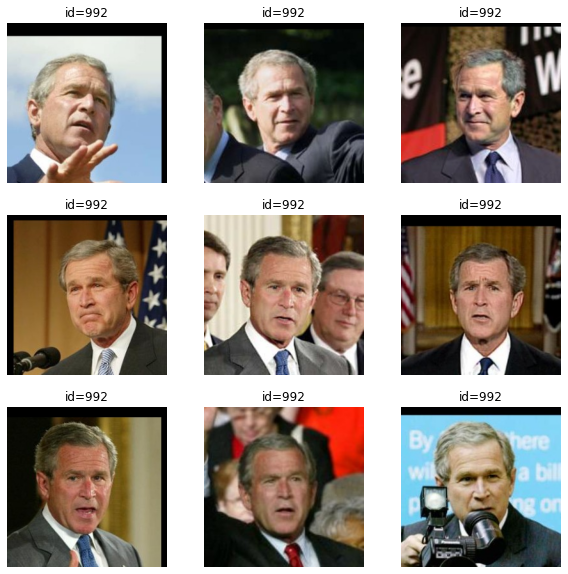

In [7]:
gallery_offset = 0 # Can be changed to "move" the gallery
gallery_width = 3 # Can be changed to resize gallery

display_images(
    people_images_np[(gallery_offset):(gallery_width**2 + gallery_offset)], 
    people_labels[(gallery_offset):(gallery_width**2 + gallery_offset)])

# Secion 2. Preprocessing

### 2.1. Forming batches of images of the same person for the lfw_people dataset

In [8]:
def form_batch_by_id(images, labels, image_id):
    """
    Get array of images of a person with specified id from the dataset
    
    Input: 
    images - array of images of shape (m, n_H, n_W, n_C)
    labels - array of labels (integers)
    image_id - id of a desired set of images
    
    Output: 
    image_batch - array of images of a person with id=person_id of shape (k, n_H, n_W, n_C)
    """
    
    _, image_height, image_width, image_channels = images.shape
    image_batch = np.empty((0, image_height, image_width, image_channels))
    
    assert len(labels) == images.shape[0], 'Labels length should match the number of images'
    
    for i in range(len(labels)):
        if labels[i] == image_id:
            image_to_concatenate = np.expand_dims(images[i], axis=0)
            image_batch = np.concatenate((image_batch, image_to_concatenate), axis=0)
            
    return image_batch

Batch shape (60, 250, 250, 3)


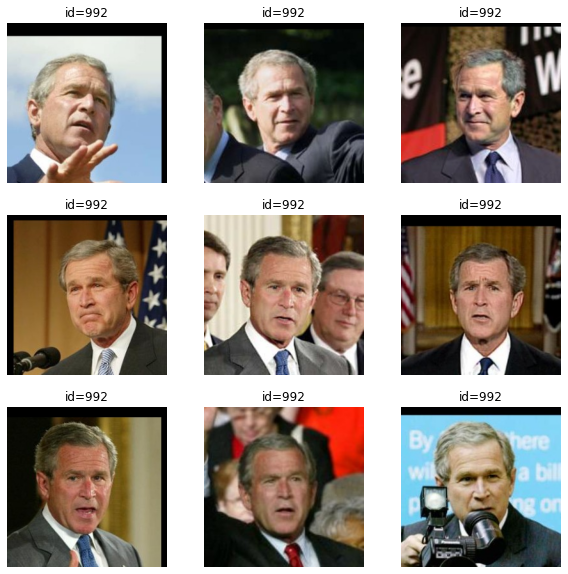

In [9]:
person_id = 992 # Person's ID to be displayed
batch = form_batch_by_id(people_images_np, people_labels, image_id=person_id) # Getting images of a person

print('Batch shape', batch.shape) # Check whether the shape is correct

# Displaying a gallery
display_images(
    batch[:(gallery_width**2)], 
    np.full((gallery_width**2), person_id, dtype=int), 
    gallery_size=3)

In [10]:
INFTY = 10000000

def form_batches_list(images, labels):
    """
    Form set of batches in which the images correspond to one single ID
    
    Input: 
    images - set of images of shape (m, n_H, n_W, n_C)
    labels - set of labels of size m
    
    Output:
    image_batches - batches of images with the same id (which equals to the index in an array)
    """
    
    image_batches = []
    for person_id in np.unique(labels):
        image_batches.append(form_batch_by_id(images, labels, person_id))
        
    return image_batches

def form_batches_numpy(images, labels):
    """
    Same as form_batches_list, but creates a batch of shape (m, k, n_H, n_W, n_C) 
    where m is a number of batches, k is a minimum size among all batches
    
    Input: Same as for form_batches_list
    Output: a set of shape (m, k, n_H, n_W, n_C)
    """
    
    # Form list of batches
    batches_list = form_batches_list(images, labels) 
    
    # Get minimum size of a batch
    min_batch_size = INFTY
    for batch in batches_list:
        min_batch_size = min(min_batch_size, batch.shape[0])
    
    _, image_height, image_width, image_channels = np.shape(images)
    batches_list_numpy = np.empty((0,min_batch_size,image_height,image_width,image_channels))
    
    for batch in batches_list:
        batch_to_concatenate = np.expand_dims(batch[:min_batch_size], axis=0)
        batches_list_numpy = np.concatenate((batches_list_numpy, batch_to_concatenate), axis=0)
    
    return batches_list_numpy

Number of batches: 8
Shape of selected batch: (60, 250, 250, 3)
Shape of numpy list of batches: (8, 60, 250, 250, 3)


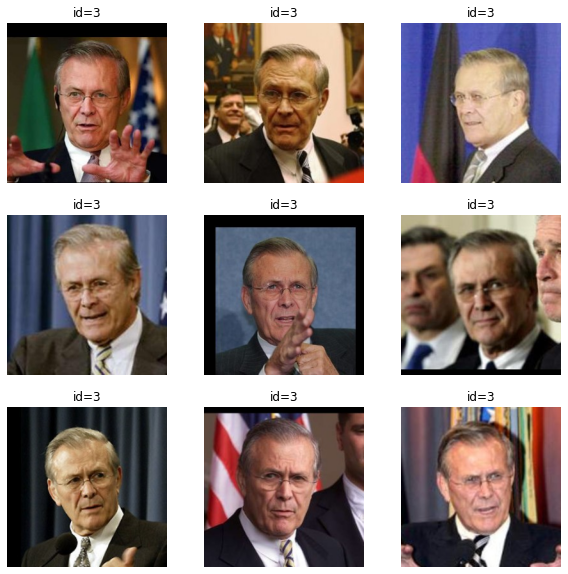

In [12]:
# Distributing images into batches of the same id
image_batches = form_batches_list(people_images_np, people_labels)
# Id of a batch to display in the gallery
image_batch_display_id = 3

# Trying to use form_batches_numpy
#image_batches_numpy = form_batches_numpy(people_images_np, people_labels)
image_batches_numpy = np.array(image_batches)

# Displaying a gallery
display_images(
    image_batches_numpy[image_batch_display_id][:(gallery_width**2)], 
    np.full((gallery_width**2), image_batch_display_id, dtype=int), 
    gallery_size=3)

# Printing some info to verify that everything was implemented properly
print('Number of batches:', len(image_batches))
print('Shape of selected batch:', image_batches[image_batch_display_id].shape)
print('Shape of numpy list of batches:', image_batches_numpy.shape)

# Section 3. Extracting features from an image using Keras Facenet

#### Loading model's weights and model itself

**Option 1.** Facenet Keras Model

In [ ]:
model = keras.models.load_model('models/facenet_keras.h5', compile=False)

**Option 2.** Face Recognition Package

Suppose we have a batch of size $n_b$ with images $I^{(1)}, I^{(2)}, \dots, I^{(n_b)}$.
Using FaceNet, we can extract a feature vector of dimension $n_f$, that is:
$$
f(I^{(j)}) = \begin{pmatrix} f(I^{(j)})_1 \\ f(I^{(j)})_2 \\ \vdots \\ f(I^{(j)})_{n_f} \end{pmatrix}
$$
To evaluate difference $d(I^{(m)}, I^{(k)})$ between images $I^{(m)}$ and $I^{(k)}$ we are going to simply take a square of the feature-vectors difference norm:
$$
d(I^{(m)}, I^{(k)}) = \| f(I^{(m)}) - f(I^{(k)}) \|^2 = \sum_{j=1}^{n_f} (f(I^{(m)})_j - f(I^{(k)})_j)^2
$$

In [13]:
import face_recognition

# Function extracted from keras facenet github
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def extract_vectors_from_batches(image_batches, mode='face_recognition', model=None):
    """
    Feature vectors extraction from image batches
    
    Input:
    image_batches -- a batch of images
    model -- FaceNet or some other model
    mode -- a string which is either 'keras_facenet' or 'face_recognition'
    
    Output:
    vector_batches -- an array of feature vectors for each batch
    """
    
    vector_batches = []
    for batch in image_batches:
        if mode == 'keras_facenet':
            batch = tf.image.resize_images(batch, [160,160])
            batch_np = batch.eval(session=tf.compat.v1.Session())
            batch_np = prewhiten(batch_np)
            vector_batch = model.predict_on_batch(batch_np)
            vector_batches.append(vector_batch)
        elif mode == 'face_recognition':
            vector_batch = []
            for person_image in batch:
                encodings = face_recognition.face_encodings(person_image.astype('uint8'))
                if len(encodings) > 0:
                    vector_batch.append(encodings[0])
            vector_batches.append(vector_batch)
            
    return vector_batches

**Distance between vectors function**

In [14]:
def feature_vectors_distance(vector1, vector2):
    """
    Returns distance between two given vectors
    
    Input:
    vector1, vector2 -- two vectors
    
    Output:
    distance between vectors
    """
    return np.sum(np.square(vector1 - vector2))

In [15]:
feature_vectors = extract_vectors_from_batches(image_batches_numpy, mode='face_recognition', model=None)

In [16]:
def distance_visualization_header(distance_title):
    plt.figure(figsize=(5,1))
    # Drawing first picture
    ax = plt.subplot(1, 3, 1)
    plt.text(0.5, 0.5, 'Image 1', fontsize='xx-large')
    plt.axis("off")
    # Drawing second picture
    ax = plt.subplot(1, 3, 2)
    plt.text(0.5, 0.5, 'Image 2', fontsize='xx-large')
    plt.axis("off")
    # Drawing a distance between them
    ax = plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, distance_title, fontsize='xx-large')
    plt.axis("off")

def distance_visualize(image1, image2, distance, distance_label=''):
    """
    Function that shows two images and distance between them on the same plot
    
    Input:
    image1, image2 - two images
    distance - distance between images
    
    """
    
    plt.figure(figsize=(5,2))
    # Drawing first picture
    ax = plt.subplot(1, 3, 1)
    plt.imshow(image1.astype("uint8"))
    plt.axis("off")
    # Drawing second picture
    ax = plt.subplot(1, 3, 2)
    plt.imshow(image2.astype("uint8"))
    plt.axis("off")
    # Drawing a distance between them
    ax = plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, 
             str(distance) if len(distance_label) == 0 else distance_label + '=' + str(distance), 
             fontsize='xx-large')
    plt.axis("off")

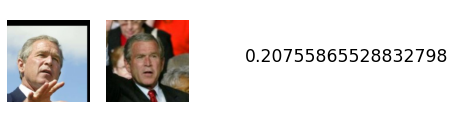

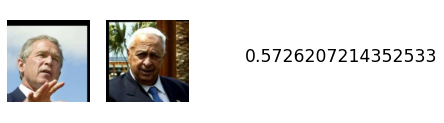

In [17]:
n1, i1, k1, j1 = 0, 0, 0, 7
n2, i2, k2, j2 = 0, 0, 1, 15


distance_visualize(image_batches[n1][i1], 
                   image_batches[k1][j1], 
                   feature_vectors_distance(feature_vectors[n1][i1], feature_vectors[k1][j1]))
distance_visualize(image_batches[n2][i2], 
                   image_batches[k2][j2],
                   feature_vectors_distance(feature_vectors[n2][i2], feature_vectors[k2][j2]))

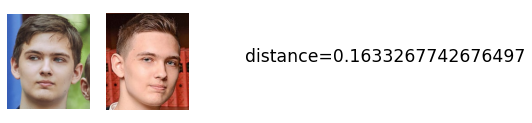

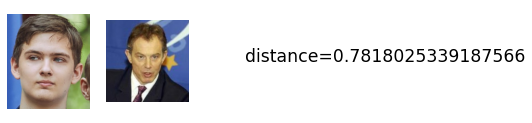

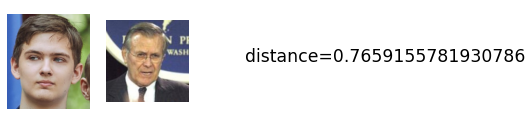

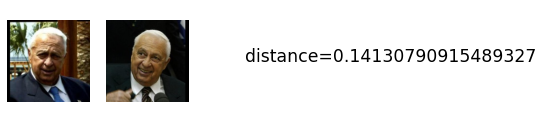

In [18]:
from PIL import Image

def get_image_features(image, mode = 'face_recognition', model = None):
    """
    Function that returns array of features for a given image 
    
    """
    if mode == 'keras_facenet':
        image_resized = tf.image.resize_images(np.expand_dims(image,axis=0), [160,160])
        image_np = image_resized.eval(session=tf.compat.v1.Session())
        image_np = prewhiten(image_np)
        vector_batch = model.predict_on_batch(image_np)
        return vector_batch[0]
    elif mode == 'face_recognition':
        return face_recognition.face_encodings(image.astype('uint8'))[0]
    
def get_distance_between_images(image1, image2):
    feature_vector_1 = get_image_features(image1)
    feature_vector_2 = get_image_features(image2)
    return feature_vectors_distance(feature_vector_1, feature_vector_2)
    
# Read image
person_1 = np.array(Image.open('Images/Dima1.png'))
person_2 = np.array(Image.open('Images/Dima2.png'))

distance_visualize(person_1, person_2, get_distance_between_images(person_1, person_2), 'distance')
distance_visualize(person_1, image_batches[2][3], get_distance_between_images(person_1, image_batches[2][3]), 'distance')
distance_visualize(person_1, image_batches[3][10], get_distance_between_images(person_1, image_batches[3][10]), 'distance')
distance_visualize(image_batches[1][15], 
                   image_batches[1][30], 
                   get_distance_between_images(image_batches[1][15], image_batches[1][30]), 'distance')

# Section 4. Estimating the accuracy

### 4.1. Defining the term "accuracy" of pair difference prediction

Now let us estimate roughly what is the accuracy of our algorithm.
Suppose we have $n_b$ batches, every one of which contains $n_i$ images:
$$
(I^{(1)}_1, I^{(1)}_2, \dots, I^{(1)}_{n_i}), (I^{(2)}_1, I^{(2)}_2, \dots\, I^{(2)}_{n_i}), \dots, (I^{(n_b)}_1, \dots, I^{(n_b)}_{n_i})
$$
In other words, $I^{(i)}_j$ is a $j$th image in $i$th batch.

We could probably use binary classification loss functions or F1 score, but we are interested not in the face recognition task, but on the feature vectors themselves as they should not differ significantly.

We will define the following "accuracy" function, where $\tau$ denotes certain threshold (in our case we have put $\tau = 100$):
$$
\alpha(I^{(n_1)}_{i_1}, I^{(n_2)}_{i_2}) = 
\begin{cases}
\max\{1- \left(\frac{d(I^{(n)}_{i_1}, I^{(n)}_{i_2})}{\tau}\right)^{\eta_1}, 0\} \; \text{if} \; n_1 = n_2 = n \\
\max\{1-\left(\frac{\tau}{d(I^{(n_1)}_{i_1}, I^{(n_2)}_{i_2})}\right)^{\eta_2}, 0\} \; \text{if} \; n_1 \neq n_2
\end{cases}
$$

The intuition behind this formula is rather simple: if both images are from the same person, then if the value is less than threshold, then the value interpolates on a segment $[0,1]$ (if distance is close to $0$, thus accuracy is close to $1$, if distance is close to $\tau$, then the accuracy tends to $0$). Same intuition if images are different, but we use the inverse relation to the power of $\eta$.

Suppose we chose $n_p$ pairs of images, each element of which has parameters $p^{(t)} = \{n^{(t)}_1, n^{(t)}_2, i^{(t)}_1, i^{(t)}_2\}$. Then our accuracy equals:
$$
\mathcal{A} = \sqrt{\frac{1}{n_p} \sum_{t=1}^{n_p} \alpha^2(I^{(n^{(t)}_1)}_{i^{(t)}_1}, I^{(n^{(t)}_2)}_{i^{(t)}_2})}
$$

We will select batches so that the number of image pairs from the same batch is the same as the number of pairs from the different batches.

In [19]:
# Finding threshold
def get_approximate_threshold(feature_vectors):
    threshold_cumulative = 0.
    for i in range(20):
        threshold_cumulative += feature_vectors_distance(feature_vectors[0][i], feature_vectors[0][i+1])
        threshold_cumulative += feature_vectors_distance(feature_vectors[0][i], feature_vectors[1][i])
    return threshold_cumulative / 40
    
print('approximate threshold:', get_approximate_threshold(feature_vectors))

approximate threshold: 0.4063657199907918


In [20]:
def calculate_accuracy(same, distance, threshold=100.0, eta_1=3.0, eta_2=3.0):
    """
    Calculates accuracy of distance evaluation based on given distance and whether 
    two images are from one batch 
    
    Inputs:
    same - boolean that equals to True if two images are of a same person and False if vice versa
    distance - distance between two images
    For meaning of other parameters see block above
    
    Output:
    accuracy - calculated value based on the block above
    """
    return max(1 - pow(distance / threshold, eta_1), 0) if same==True else max(1 - pow(threshold/distance, eta_2), 0)   

def calculate_pair_accuracy(feature_vectors, n1, i1, n2, i2, threshold=100, eta_1=3.0, eta_2=3.0):
    """
    Calculates accuracy of distance evaluation between two given pages
    
    Inputs:
    feature_vectors - set of vector batches of shape (n_b, n_i,)
    n1, n2 - number of batch of the first and second image, respectively
    i1, i2 - number of images in the first (n1) and second (n2) batch, respectively
    
    Output:
    accuracy - calculated value based on the block above
    """
    
    distance = feature_vectors_distance(feature_vectors[n1][i1], feature_vectors[n2][i2])
    return calculate_accuracy(n1 == n2, distance, threshold=threshold, eta_1=eta_1, eta_2=eta_2)

In [21]:
# Checking whether calculation of accuracy is good enough 

# Expected value: 1 - (100/200)^3 = 0.875 
print('If batches are different and distance=200, accuracy equals', calculate_accuracy(False, 200))
# Expected value: 0 
print('If batches are the same and distance=200, accuracy equals', calculate_accuracy(True, 200))
# Expected value: 0
print('If batches are the different and distance=90, accuracy equals', calculate_accuracy(False, 90))
# Expected value: 1 - (64/100)^(3) = 0.737856 
print('If batches are the same and distance=64, accuracy equals', calculate_accuracy(True, 64))

If batches are different and distance=200, accuracy equals 0.875
If batches are the same and distance=200, accuracy equals 0
If batches are the different and distance=90, accuracy equals 0
If batches are the same and distance=64, accuracy equals 0.737856


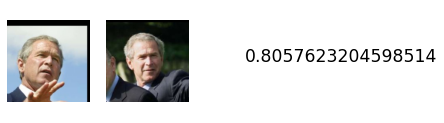

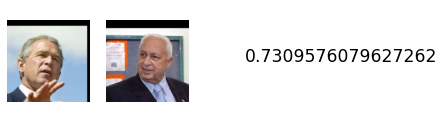

In [22]:
#Visualization of accuracy between images

distance_visualize(image_batches[0][0], 
                   image_batches[0][1], 
                   calculate_pair_accuracy(feature_vectors, 0, 0, 0, 1, threshold=0.4))
distance_visualize(image_batches[0][0], 
                   image_batches[1][0], 
                   calculate_pair_accuracy(feature_vectors, 0, 0, 1, 0, threshold=0.4))

In [23]:
def calculate_pairs_accuracy(pairs, feature_vector_batches, threshold=100):
    """
    Calculates cumulative accuracy after comparing multiple pairs of vectors
    
    Input:
    pairs -- two-dimensional array each element of which corresponds to [n1, i1, n2, i2]
    feature_vector_batches -- array of feature vectors
    
    Output:
    accuracy -- cumulative accuracy
    """
    accuracies = np.empty((1,0))
    
    for pair in pairs:
        n1, i1, n2, i2 = pair
        accuracies = np.append(accuracies, calculate_pair_accuracy(feature_vector_batches, n1, i1, n2, i2, threshold=threshold))
    
    return np.sqrt(np.mean(accuracies**2))    

def calculate_pairs_binary_accuracy(pairs, feature_vector_batches, threshold=100):
    """
    Calculates cumulative accuracy by calculating number 
    of successfull recognitions to the total number of guesses
    
    Input:
    pairs -- two-dimensional array each element of which corresponds to [n1, i1, n2, i2]
    feature_vector_batches -- array of feature vectors
    
    Output:
    accuracy -- cumulative accuracy obtained by method described above
    """
    
    accuracies = np.empty((1,0))
    
    for pair in pairs:
        n1, i1, n2, i2 = pair
        current_accuracy = calculate_pair_accuracy(feature_vector_batches, n1, i1, n2, i2, threshold=threshold)
        accuracies = np.append(accuracies, 0.0 if current_accuracy <= 0.01 else 1.0)
    
    return np.mean(accuracies)    
 

In [24]:
accuracy = calculate_pairs_accuracy([[0, 0, 0, 1], [0, 0, 1, 0]], feature_vectors, threshold=0.4)
print('Cumulative accuracy for two images above is', accuracy)

Cumulative accuracy for two images above is 0.7692697646831815


### 4.2. Forming set of pairs

In [25]:
def get_minimal_batch_size(feature_vectors):
    minimal_batch_size = 10000000
    for batch in feature_vectors:
        minimal_batch_size = min(minimal_batch_size, len(batch))
    
    return minimal_batch_size

def form_pairs_list(feature_vectors_shape, fixed_size = None):
    """
    Forms list of pairs of shape (n_p, 4) where n_p is a number of pairs and 
    each element corresponds to the numbers (n_1, i_1, n_2, i_2)
    
    Input:
    feature_vectors_shape - shape of feature_vectors array
    
    Output: See description of the function
    """
    
    pairs = []
    pairs_number_in_row = int(np.floor(feature_vectors_shape[1]/2))
    
    for batch in range(feature_vectors_shape[0] - 1):
        for i in range(pairs_number_in_row):
            pairs.append([batch, 2*i, batch, 2*i + 1])
        for i in range(pairs_number_in_row):
            pairs.append([batch, i, batch + 1, i])
        
    return pairs

In [31]:
# Forming a list of pairs
pairs = form_pairs_list((len(feature_vectors), get_minimal_batch_size(feature_vectors)))

# Getting accuracy
print('Total accuracy is', calculate_pairs_accuracy(pairs, feature_vectors, threshold=0.3))
print('Total binary accuracy is', calculate_pairs_binary_accuracy(pairs, feature_vectors, threshold=0.35))

Total accuracy is 0.8227632544954012
Total binary accuracy is 0.9876847290640394


# Section 5. Saving the feature vector data to the CSV file

In [32]:
def form_row_csv(feature_vectors, person_id, image_id):
    """
    Returns an array that corresponds to a single row in the csv file
    """
    
    row = [person_id, image_id]
    return np.append(row, feature_vectors[person_id][image_id])

def form_rows_csv(feature_vectors):
    """
    Returns an array with rows used to load the csv file
    """
    
    rows = []
    for person_id in range(len(feature_vectors)):
        for image_id in range(len(feature_vectors[person_id])):
            rows.append(form_row_for_csv(feature_vectors, person_id, image_id))
            
    return rows

def form_header_csv(vector_dimension):
    """
    Forms a header for the CSV file
    
    Input:
    vector_dimension -- integer that represents the dimensionality of the vector
    """
    
    header = ['person_id', 'image_id']
    for vector_id in range(vector_dimension):
        header.append('feature_' + str(vector_id))
        
    return header

In [33]:
import csv

# Load the CSV file
with open('datasets/keras_facenet_feature_vectors.csv', 'w') as dataset:
    # Create a writer
    writer = csv.writer(dataset)
    
    # Write a header
    vector_dimension = len(feature_vectors[0][0])
    writer.writerow(form_header_csv(vector_dimension))
    
    # Write rows
    writer.writerows(form_rows_csv(feature_vectors))

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/keras_facenet_feature_vectors.csv'

### Section 6. Binary string 

In [38]:
def form_string_batches(feature_vectors):
    string_batches = []
    
    for batch in feature_vectors:
        string_batch = []
        for feature_vector in batch:
            string_batch.append(form_binary_string(feature_vector))
        string_batches.append(string_batch)
    return string_batches
        
def form_binary_string(feature_vector):
    binary_string = ''
    for vector_element in feature_vector:
        binary_string += ('0' if vector_element <= 0 else '1')
        
    return binary_string

def binary_string_difference(string_1, string_2):
    assert len(string_1) == len(string_2), 'strings length must match'
    
    total_difference = 0
    for i in range(len(string_1)):
        total_difference += abs(int(string_1[i]) - int(string_2[i]))
    
    return total_difference / len(string_1)

In [46]:
string_batches = form_string_batches(feature_vectors)

In [54]:
def get_average_difference_between_same_batches(string_batches):
    distances = []
    
    for batch in string_batches:
        for i in range(len(batch) - 1):
            distances.append(binary_string_difference(batch[i], batch[i+1]))
            
    return np.mean(distances)

def get_average_difference_between_different_batches(string_batches):
    distances = []
    
    for i in range(len(string_batches) - 1):
        for j in range(min(len(string_batches[i]), len(string_batches[i+1]))):
            distances.append(binary_string_difference(string_batches[i][j], string_batches[i+1][j]))
            
    return np.mean(distances)

In [55]:
print(get_average_difference_between_same_batches(string_batches))
print(get_average_difference_between_different_batches(string_batches))

0.1080812101910828
0.19839638157894737
